# [Going Deeper NLP 02] SentencePiece

Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 패키지인 SentencePiece를 사용하는 프로젝트입니다. 

---

## 프로젝트 목표
---
- 한국어로 구성된 네이버 영화리뷰 감정분석 문제에 SentencePiece를 적용한다. 
- Unet, generator, discriminator레이어를 구성한다.


## 프로젝트 설명
---
1. 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기

2. 학습된 모델로 sp_tokenize() 메소드 구현하기

3. 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 재학습하기

4. KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

5. (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

6. Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

7. 머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것입니다.

## 1. 데이터 불러오기 및 전처리

In [83]:
import pandas as pd
import sentencepiece as spm
import urllib.request
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f015c5e5850>)

In [18]:
naver_df = pd.read_table('ratings.txt')
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [19]:
print('데이터 개수 :', len(naver_df))

데이터 개수 : 200000


### 결측치, 중복 확인 및 제거

In [20]:
origin_len = len(naver_df)

In [22]:
naver_df.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [23]:
naver_df = naver_df.dropna(how='any')
print(naver_df.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[199992 rows x 3 columns]>


In [24]:
print('결측치 제거 후 데이터 개수 :', len(naver_df))

결측치 제거 후 데이터 개수 : 199992


In [25]:
naver_df.drop_duplicates(['document'], inplace=True)

In [26]:
print('중복 제거 후 데이터 개수 :', len(naver_df))

중복 제거 후 데이터 개수 : 194543


In [27]:
print('전처리 전 데이터 개수 :', origin_len)
print('전처리 후 데이터 개수 :', len(naver_df))
print('전처리 후 남은 데이터 양(%)', (len(naver_df)/origin_len)*100)

전처리 전 데이터 개수 : 200000
전처리 후 데이터 개수 : 194543
전처리 후 남은 데이터 양(%) 97.2715


In [28]:
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [29]:
naver_review = naver_df['document']

### 데이터 분석 및 전처리

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


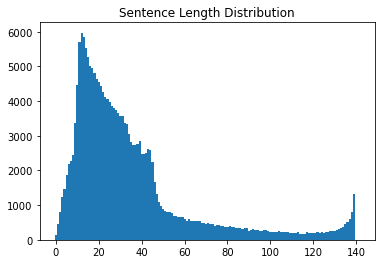

In [30]:
min_len = 999
max_len = 0
sum_len = 0

for sen in naver_review:
    length = len(sen)
    if min_len > length: 
        min_len = length
        
    if max_len < length: 
        max_len = length
    
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(naver_review))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in naver_review:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

**최장 길이 142에 가까운 데이터가 꽤 많습니다. 어떤 문장인지 확인해봅니다.** 

In [31]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return 

check_sentence_with_length(naver_review, 135)

내가 남자라그런가 이거 겁나 긴장감있고 흥미진진하던데..ㄷㄷ 나만그런가워낙에 격투씬을 좋아해서.ㅋㅋㅋ 그냥 아무생각없이 집에서 스마트티비로 봐서 재밌었나봄 이거 뭔영화인지도 모르고 암살에 나온 이정재 있길래 걍봄 ㅋㅋ 하여튼 너무 재밌게 봤음
줄리아 로버츠의 웃음은 정말 보는 사람을 기쁘게 해준다. 웃음 하나로 기쁨과 슬픔을 표현할 수 있는 배우..전통을 깨고 여성의 새로운 삶을 살으라고 영화는 보여주는 데 영화에서는 전통을 완전히 벗어나야 한다는 것만을 강조하는 것 같아 아쉽다.
평점 왜 이렇게 낮아요??? 영화 대박인데...진짜....ㅋㅋㅋ 와.. 어떻게 이런상상을 해서 이런 영화를... 대박대박.. ㅠ 생각지못한 반전.. 처음엔 반신반의하면서 봤는데.. 최고내요...ㄷㄷㄷ 근데 금발 여주는 중반에 좀 짜증나긴했음ㅋ
큰 기대 안하고 띄엄띄엄 보다가 집중해서 봤네요!! 저는 잘봤습니다. 액션도 뛰어나고 아슬아슬한 장면들을 극복해 가는게 나름 잼있었어요!! 마지막에 여자 박사가 살았는지 죽었는지가 안나와서 좀 아쉽네요..그래도 딸은 살렸으니 다행스럽다는 ㅎㅎ
누군가는 잃고, 누군가는 벌고, 또 누군가는 죽는 게임. 그리고 끊임없이 반복되는 삶과 기억의 굴레. 하지만 시작할 때부터 영화는 이미 심각했고, 지루했다. 다 본 후 생각해보니 그럴 수밖에 없었겠다 싶다. 넓고 얕은 재미, 길고 깊은 여운.
영화내용은 사실별거 없지만 보고나면 생각을 많이하게 되는 영화임. 재미있기도 하고, 결론은 무엇이냐 하면 빨갱이들이 아무것도 모르는 사람들 선동해서 비참한 결과를 낳게 한다는 내용임. 복수심에 불타는 이북출신들도 나오는데 다 역사적인 사실임.
고등학교때 보고 지금에서 생각난 영화 참~그땐 눈물 콧물 흘리면서 봤는데짐 보면 나올라나.. 하긴 세월이 많이 흘렀지 아마 짐 시대하곤 스토리자체가 뻔하니깐 하지만 지금도 잊혀지지않는장면은 주인공이 공부하는장면과하늘도 갈라놓지 못한 그들의사랑
오스카는 흔히 볼수있는 아들이자 장난끼 많은 오빠 그리고 항상 미안해하는 남편. 감정이

In [32]:
# sentence_length[문장 길이] = 갯수 
# idx = 문장길이 , _sum = 해당 문장 길이인 문장의 개수 

for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 135 초과하는 문장 길이를 추출합니다.
    if _sum > 135:
        print("Outlier Index:", idx+1)

Outlier Index: 2
Outlier Index: 3
Outlier Index: 4
Outlier Index: 5
Outlier Index: 6
Outlier Index: 7
Outlier Index: 8
Outlier Index: 9
Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47
Outlier Index: 48
Outlier Index: 49
Outlier Index: 50
Outlier Index: 51
Outlier Index: 52
Outlier Index: 53
Outlier Index: 54
Outlier Index: 55
Outlier Index: 56
Outlier Index: 57


**문장 길이 10 이하의 문장을 확인해봅니다.**

In [33]:
check_sentence_with_length(naver_review, 1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


In [34]:
check_sentence_with_length(naver_review, 8)

내 인생의 영화
ㅎㅎㅎㅎㅎㅎㅎㅎ
역시 최고였다.
잘나갔지 콜트~
나수윤의 발견!
정말 멋진 영화
매력넘치는 영화
넘넘 재밌있었습
훈훈한 영화~~
참재밌게 봤다.
무섭고 아쉽다.
재미있었스니다.
그냥 킬링타임용
후회없는 영화!
배창호 최고걸작
행복한영호ㅓㅠㅠ
재미 있습니다.
모스크바가고싶다
이건진짜명작이죠
주옥 같은 영화
재밌었어요ㅋㅋㅋ
동양화같은 영화
재밌는다큐였어요
최고의영화...
정말재밌어용..
가슴 아파요..
말이필요없지,,
그냥 좋다 ㅎㅎ
최고의 영화다.
최고의순수의영화
다시봐도 재밌다
감동 적인 내용
재밌어요~ ㅋㅋ
멋지다 조문탁!
재밌어요 ㅋㅋㅋ
재미있고 참신함
런닝맨완전재밌음
난 재밌던데..
오아오어ㅓ오ㅓ아
재미있네요 !!
즐겨보고있어요!
즐거운 영화..
정말 웃기네요.
말이 필요 없다
난해하다 외롭다
재미있다~~~!
꺄아~귀요미들~
어쩜 절묘한지.
멋있으세요 ^^
엄청 웃낌 ㅋㅋ
참 평화로워요.
잠안올때 강추!
좋다라는 말밖에
웨스턴의 교과서
단 하나의 사랑
걍대박.....
재밌어어용~~~
끝까지 몰입이됨
너무 재밌었어요
아름다운 성장기
전설에 동감..
30번 넘게봤다
떡밥계의 최고봉
어떻게봐요이거?
굿굿굿 굿이에요
추억돋네요 ㅎㅎ
걍 재미잇는영화
재밌던데 뭘ㅎㅎ
완전 재밋습니다
좋은 영화네요.
ㅋㅋㅋㅋㅋ재밌당
느낌 좋은 영화
감동ㅠㅠㅠㅠㅠㅠ
대단한 영화였음
좋다 진짜;;;
재미있었는데..
넘재밋다 ㅋㅋㅋ
재밋어요 짱짱짱
최고의우정이다.
프랑스로 갈래~
재미있어요 ㅋㅋ
박지윤씨 이뻐요
잔잔한웃음 ^^
하지원 레전드임
이젠 잘 살아라
매력적인 무비;
평점이 왜이러냐
재미있게 보았다
게리올드만 최고
감동적입니다^^
스토리탄탄 ㅠㅜ
히트 재밋죠 ㅎ
되게 묘함...
마음에 듭니다.
정말 완벽했다.
솔까 재밌는데?
말이 필요없음.
신정환컴백하라~
다시봐도 최고.
까브리머싯씀ㅎㅎ
샘이 돌아왔다.


In [35]:
check_sentence_with_length(naver_review, 2)

쵝오
최고
좋아
흐흐
개쩜
굳뜨
좋다
섬뜩
♥♥
ㅎㅎ
대박
잼슴
굳굳
10
ㄹㄹ
윤하
유쾌
긋~
잼남
박수
수작
굳!
졸잼
꿈.
쏘우
굿!
명작
대작
잼네
맞아
ㅇㅇ
완벽
오우
굿굿
ㅠㅠ
굿잡
와우
..
좋네
無言
미투
gg
ㅋㅋ
후훗
걸작
잼잼
나두
예뻐
^^
만점
웃김
오호
설리
좋너
의읭
감동
원작
구ㄷ
하하
좋음
조앙
멋져
매력
개박
조음
추천
탁월
조아
쩔어
감독
가슴
재밋
잼씀
진리
붉다
눈물
오오
9점
zz
잼따
1등
짱임
홧팅
쳐봐
신고
짱♥
ㅡㅡ
역시
뻥임
섹시
명품
우정
짱~
동참
짱짱
야한
ㅊㅊ
굿~
대단
반담
만족


In [36]:
check_sentence_with_length(naver_review, 3)

재밌다
가연세
재밋다
야마켄
재밌음
좋아요
괜찮네
화려함
좋은데
짱~~
재밋음
굿..
킹왕짱
재밌어
까까~
진짜다
재밌당
명작.
잼있다
재미다
재미짐
몽정기
최고다
각키♥
수작.
참재미
채고야
베리굳
김은미
굿!!
갑이다
구여움
좋구나
행~복
10점
ㅎ최고
재밌군
멋지당
최고임
똥파리
잘봤음
...
조아요
하하하
굿굿굿
훌륭함
재미닷
재밋당
좋ㅎ음
쩐다;
ㅋㅋㅋ
개코미
화이팅
잼네요
귀여움
으리!
좋다.
팬심♥
볼만함
감동적
감동임
감동~
패닝짱
목두기
괜찬네
재미씀
좋네요
참좋다
동감.
ㅋ재미
재밋쪼
한석규
재밌긔
웃긴데
감동!
ㅎㄷㄷ
아프다
대단함
걸작.
람보3
명작!
나의꿈
잼겟따
신선함
갱호~
재밌네
대박!
^-^
연출력
오ㅓㅏ
재및음
굿 ㅋ
오호호
괜찮음
드라마
zzz
최고!
감동함
짱짱맨
구구굿
멋있다


Data Size: 194543
문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


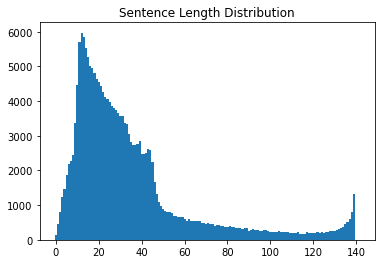

In [37]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(naver_review))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

**"문장길이 <= 100"으로 처리해줍니다.**

182732 182732


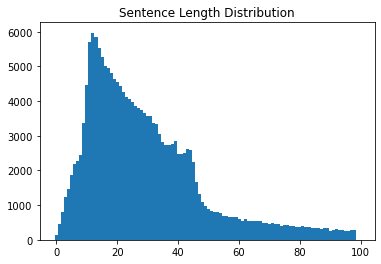

In [38]:
max_len = 100
# min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len)]

filtered_label = []
for row, label in zip(naver_df['document'], naver_df['label']):
    if (len(row) < max_len):
        filtered_label.append(label) 

print(len(filtered_corpus), len(filtered_label))

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [39]:
print('전처리 전 데이터 개수 :', len(naver_df))
print('전처리 후 데이터 개수 :', len(filtered_corpus))
print('전처리 후 남은 데이터 양(%)', (len(filtered_corpus)/len(naver_df))*100)

전처리 전 데이터 개수 : 194543
전처리 후 데이터 개수 : 182732
전처리 후 남은 데이터 양(%) 93.92884863500615


In [ ]:
# def tokenize(corpus):  # corpus: Tokenized Sentence's List
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
#     tokenizer.fit_on_texts(corpus)

#     tensor = tokenizer.texts_to_sequences(corpus)

#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

#     return tensor, tokenizer

## 2. SentencePiece 모델 학습

In [41]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

# vocab size=8000, model_type=unigram
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_unigram_8k --vocab_size={}'.format(temp_file, vocab_size)    
)

# 왜인지 오류가 나서 학습이 되지 않음 
# vocab size=16000, model_type=unigram
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_uingram_k --vocab_size={}'.format(temp_file, 10000)    
)

# vocab size=8000, model_type=bpe
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

# vocab size = 16000, model_type=bpe
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_16k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size*2)    
)

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

In [42]:
!ls -l kor_spm_unigram_8k*
!ls -l kor_spm_unigram_16k*
!ls -l kor_spm_bpe_8k*
!ls -l kor_spm_bpe_16k*

-rw-r--r-- 1 aiffel-dj26 aiffel-dj26 375116  4월 20 02:22 kor_spm_unigram_8k.model
-rw-r--r-- 1 aiffel-dj26 aiffel-dj26 144574  4월 20 02:22 kor_spm_unigram_8k.vocab
ls: cannot access 'kor_spm_unigram_16k*': No such file or directory
-rw-r--r-- 1 aiffel-dj26 aiffel-dj26 370628  4월 20 02:22 kor_spm_bpe_8k.model
-rw-r--r-- 1 aiffel-dj26 aiffel-dj26 115842  4월 20 02:22 kor_spm_bpe_8k.vocab
-rw-r--r-- 1 aiffel-dj26 aiffel-dj26 523675  4월 20 02:22 kor_spm_bpe_16k.model
-rw-r--r-- 1 aiffel-dj26 aiffel-dj26 258885  4월 20 02:22 kor_spm_bpe_16k.vocab


**학습된 subwords를 확인합니다.**

In [43]:
vocab_list = pd.read_csv('kor_spm_unigram_8k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.28356
4,.,-3.47793
5,..,-4.30806
6,이,-4.43464
7,▁영화,-4.48224
8,...,-4.54194
9,가,-4.72835


In [44]:
print('subword의 개수 :', len(vocab_list))
vocab_list.sample(10)

subword의 개수 : 8000


,0,1
5744,섬,-10.55310
6408,▁뛰어넘는,-10.74440
6060,▁격투,-10.63700
1228,▁어느,-8.90350
151,▁것,-7.15528
555,▁주인공,-8.19596
3517,▁하네요,-9.93270
5708,▁뭐라고,-10.54340
4691,몸,-10.27950
4069,▁좋았지만,-10.10360


### SentencePiece 성능 비교평가
- vocab size = 8k, 16k
- model type = unigram, bpe


- kor_spm_unigram_8k
- kor_spm_unigram_16k
- kor_spm_bpe_8k
- kor_spm_bpe_16k

In [53]:
def test_performance(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [70]:
print('kor_spm_unigram_8k')
test_performance(model='kor_spm_unigram_8k.model')

# unigram은 오류가 나서 학습이 되지 않았다. 
# print('kor_spm_unigram_16k')
# test_performance(model='kor_spm_unigram_16k.model')

print('kor_spm_bpe_8k')
test_performance(model='kor_spm_bpe_8k.model')

print('kor_spm_bpe_16k')
test_performance(model='kor_spm_bpe_16k.model')

kor_spm_unigram_8k
[1509, 9, 406, 15, 1342, 9, 138, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bpe_8k
[5057, 912, 6550, 6283, 1469, 6279, 6385, 6273, 6271]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bpe_16k
[7880, 10978, 1469, 14279, 12313, 14271]
['▁아버지가', '방에', '들어', '가', '신다', '.']
아버지가방에들어가신다.


**bpe, vocab size 16k로 설정한 모델이 '아버지가', '방에'를 구분하였다.**

## 3. Tokenizer 함수 작성 
- 훈련시킨 SentencePiece를 활용해 tokenizer역할을 하는 함수를 정의합니다. 
- 함수의 조건 
    1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.
    2. 생성된 vocab 파일을 읽어와 \{ \<word> : \<idx> } 형태를 가지는 word_index 사전과 { \<idx> : \<word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.
    3. 리턴값인 tensor는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [71]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./kor_spm_bpe_16k.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=max_len)

    return tensor, word_index, index_word

In [95]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()
# s.Load('kor_spm_bpe_16k.model')  # lstm 학습시 오류

s.Load('kor_spm_unigram_8k.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)
# print(word_index)
# print(index_word)

[[ 558 3386   14 1379 2213    4    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [1580 2273  253  592    9    3   16 7937  688    8    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

## 4. lstm으로 감정분석 모델 학습 
- SentencePiece 토크나이저가 적용된 모델을 학습 후 수렴하는 것을 확인합니다.
- SentencePiece 토크나이저 성능 평가

In [96]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)

In [97]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(filtered_label)
x_train, x_test, y_train, y_test = train_test_split(tensor, filtered_label, test_size=0.2)

In [98]:
print(len(x_train), len(x_test))
print(len(y_train), len(y_test))

146185 36547
146185 36547


In [99]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200  

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim)   
              ) 
model_LSTM.add(keras.layers.LSTM(512))   
model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1460224   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 3,460,737
Trainable params: 3,460,737
Non-trainable params: 0
_________________________________________________________________


**bpe, vocab size 16k로 설정한 모델은 에러가 났다.**

In [93]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
batch_size=1000

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

Train on 146185 samples
Epoch 1/10
  1000/146185 [..............................] - ETA: 3:32

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[751,1] = 14292 is not in [0, 10000)
	 [[node sequential_3/embedding_1/embedding_lookup (defined at <ipython-input-93-dae0afa237b2>:12) ]]
  (1) Invalid argument:  indices[751,1] = 14292 is not in [0, 10000)
	 [[node sequential_3/embedding_1/embedding_lookup (defined at <ipython-input-93-dae0afa237b2>:12) ]]
	 [[Adam/Adam/update/AssignSubVariableOp/_41]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_3817]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_3/embedding_1/embedding_lookup:
 sequential_3/embedding_1/embedding_lookup/2646 (defined at /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/contextlib.py:112)

Input Source operations connected to node sequential_3/embedding_1/embedding_lookup:
 sequential_3/embedding_1/embedding_lookup/2646 (defined at /home/aiffel-dj26/anaconda3/envs/aiffel/lib/python3.7/contextlib.py:112)

Function call stack:
distributed_function -> distributed_function


In [100]:
model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10
batch_size=1000

history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1)

Train on 146185 samples
Epoch 1/10
146185/146185 [==============================] - 41s 284us/sample - loss: 0.6933 - accuracy: 0.5024
Epoch 2/10
146185/146185 [==============================] - 39s 270us/sample - loss: 0.6932 - accuracy: 0.5040
Epoch 3/10
146185/146185 [==============================] - 40s 270us/sample - loss: 0.6932 - accuracy: 0.5028
Epoch 4/10
146185/146185 [==============================] - 40s 270us/sample - loss: 0.6931 - accuracy: 0.5029
Epoch 5/10
146185/146185 [==============================] - 40s 271us/sample - loss: 0.6931 - accuracy: 0.5030
Epoch 6/10
146185/146185 [==============================] - 40s 271us/sample - loss: 0.6931 - accuracy: 0.5041
Epoch 7/10
146185/146185 [==============================] - 40s 270us/sample - loss: 0.6931 - accuracy: 0.5041
Epoch 8/10
146185/146185 [==============================] - 40s 272us/sample - loss: 0.6931 - accuracy: 0.5041
Epoch 9/10
146185/146185 [==============================] - 40s 271us/sample - loss: 0.6

# 루브릭 평가
---
1. **SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?**   

    - 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?


2. **SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?**

    - SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
     
     
3. **SentencePiece의 성능을 다각도로 비교분석하였는가?** 

    - SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

    
    
# 회고
---

## 다짐